In [0]:
!unzip -q human_seg.zip

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import keras
from glob import glob
import cv2

from lib import *
import os

%matplotlib inline

In [115]:
!pip install segmentation_models
import segmentation_models as sm

In [116]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Отчет

Для удобства дальнейшей работы была создана функция to_DataFrame, которая создаёт таблицу с путями до исходных изображений и соответствующих им масок, генератор generate_data, функция ResultsValid, возвращающая Dataframe с предсказаниями модели для валидационного датасета, функция ResultsTest возвращает маски на тестовом датасете и прочие вспомогательные функкции, которые содержатся в functions.py.

Посмотрим на данные:

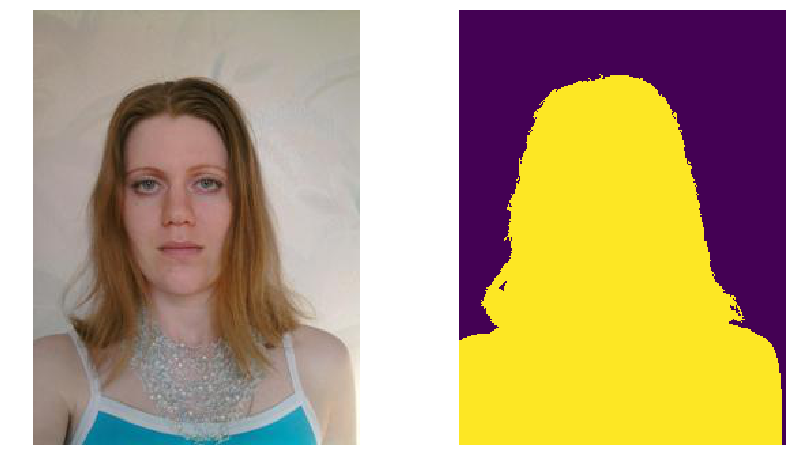

In [5]:
path = "data/train"
images = os.listdir(path)
ind = np.random.choice(images).split(".")[0]

img = np.array(Image.open(f"{path}/{ind}.jpg"))
mask = np.array(Image.open(f"{path}_mask/{ind}.png"))
show_img_with_mask(img, mask)

В train-датасете содержится 1315 фото. Так как это не слишком большое количество обучающей выборки (и так как нет возможности долго обучать чистую сеть), было принято решение использовать предобученную модель. В качестве архитектуры нейронной сети выбрана U-net. В качестве Backbone-a берется Resnet-34. В ряде экспериментов в процессе работы над задачей данный выбор показал оптимальные результаты с точки зрения времени обучения и соответствующего значения dice-score-а.
Для создания модели используется библиотека Segmentation models. (https://github.com/qubvel/segmentation_models).

In [0]:
'''' Создадим трейновый и валидационный DataFrame, содержащий пути к фото и соответстующие им закодированные маски. ''''
dft=to_DataFrame('train', 'train_mask')
dfv=to_DataFrame('valid', 'valid_mask')

In [117]:
dft.head()

,img,mask
0,/content/data/valid/1315.jpg,68 118 307 120 545 123 784 125 1023 126 1262 1...
1,/content/data/valid/1316.jpg,8036 1 8052 1 8274 3 8284 3 8288 9 8512 4 8521...
2,/content/data/valid/1317.jpg,8759 4 8999 6 9011 1 9222 2 9225 1 9238 10 924...
3,/content/data/valid/1318.jpg,10967 5 11204 9 11443 11 11682 12 11710 8 1192...
4,/content/data/valid/1319.jpg,24554 32 24791 40 25029 45 25267 50 25506 54 2...


In [0]:
'''Инициализируем модель с соответствующим backbone, претрейненную на Imagenet. '''
BACKBONE = 'resnet34'
model_res34 = sm.Unet(BACKBONE, encoder_weights='imagenet')


In [0]:
'''Создадим чекпоинты модели.'''
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

In [0]:
'''Инициализируем число эпох и оптимизатор. В данном случае испоьзуется Adam с learning rate decay. 
Число эпох выбрано исходя из экспериментов, как соответствующее выходу лосса на валидации на плато.
В качестве лосс-функции берется jaccard_loss, в качестве метрики Dice coefficient.'''
epochs=50
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-2/epochs)
model_res34.compile(
    'Adam',
    loss=sm.losses.jaccard_loss,
    metrics=[sm.metrics.dice_score],
)

In [125]:
'''Задаем размер батча и обучаем модель, используя ранее реализованные генераторы'''
batch_size = 16
history=model_res34.fit_generator(generate_data(dft, batch_size),
              steps_per_epoch=100,
              epochs=epochs,
              verbose=1,
              callbacks=callbacks,
              validation_data=generate_data(dfv, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=False,
              initial_epoch=0)

Epoch 1/50
100/100 [==============================] - 83s 827ms/step - loss: 0.1914 - score: 0.8859 - val_loss: 0.1849 - val_score: 0.8877
Epoch 2/50
100/100 [==============================] - 71s 707ms/step - loss: 0.1128 - score: 0.9360 - val_loss: 0.1611 - val_score: 0.9057
Epoch 3/50
100/100 [==============================] - 71s 708ms/step - loss: 0.0987 - score: 0.9446 - val_loss: 0.1012 - val_score: 0.9432
Epoch 4/50
100/100 [==============================] - 71s 706ms/step - loss: 0.0834 - score: 0.9539 - val_loss: 0.1027 - val_score: 0.9434
Epoch 5/50
100/100 [==============================] - 71s 709ms/step - loss: 0.0791 - score: 0.9567 - val_loss: 0.1059 - val_score: 0.9395
Epoch 6/50
100/100 [==============================] - 71s 708ms/step - loss: 0.0729 - score: 0.9603 - val_loss: 0.1084 - val_score: 0.9378
Epoch 7/50
100/100 [==============================] - 71s 707ms/step - loss: 0.0677 - score: 0.9633 - val_loss: 0.0869 - val_score: 0.9513
Epoch 8/50
100/100 [=======

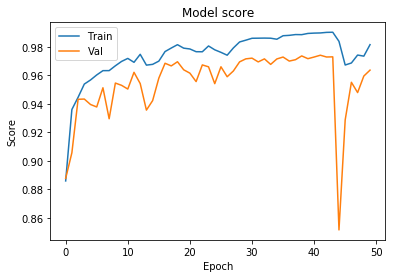

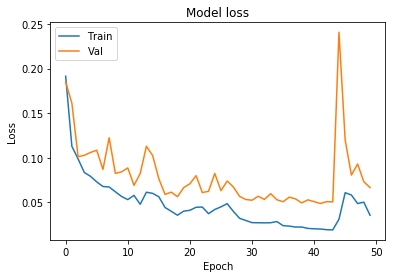

In [129]:
'''Построим графики скора и лосса. '''
Plot_graph(history)

(16, 256, 256, 1)


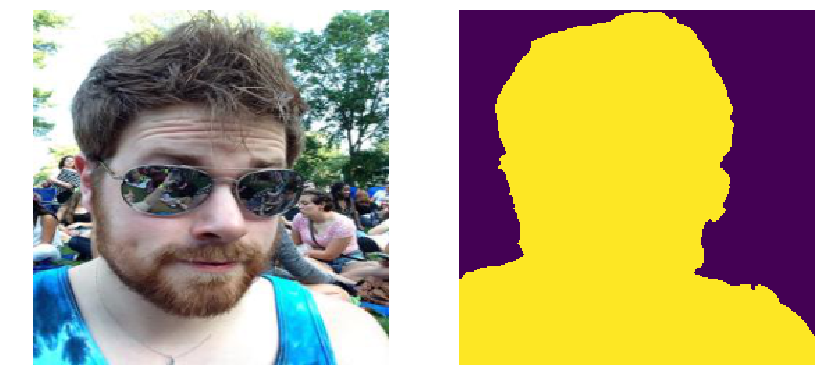

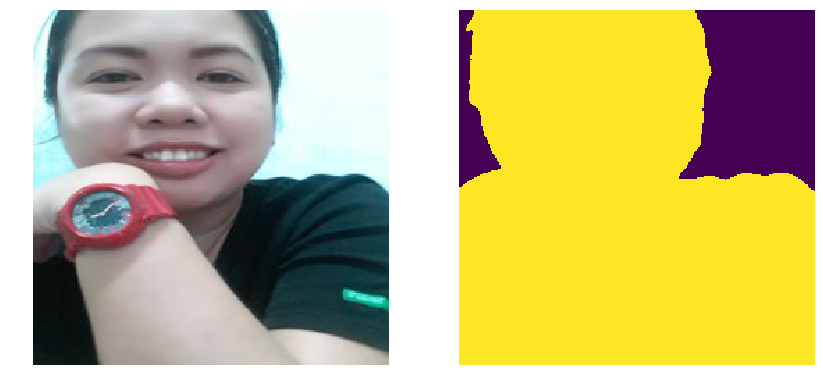

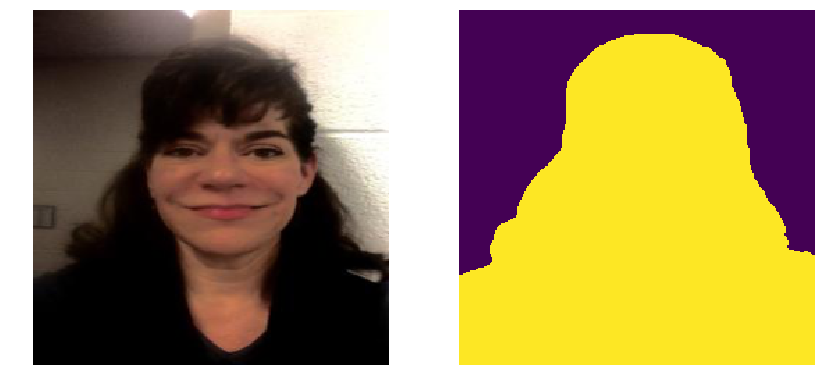

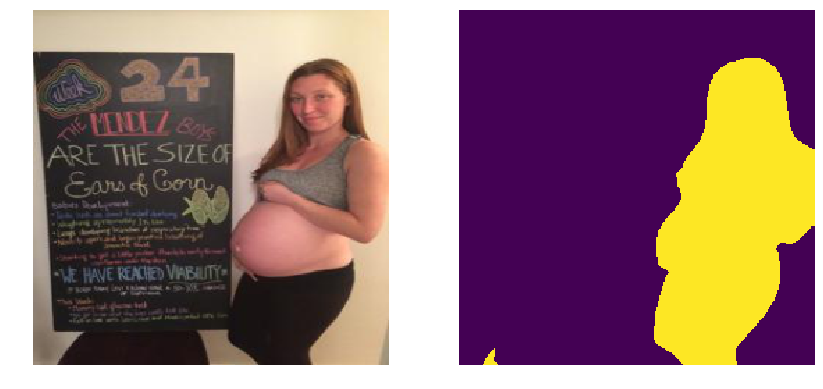

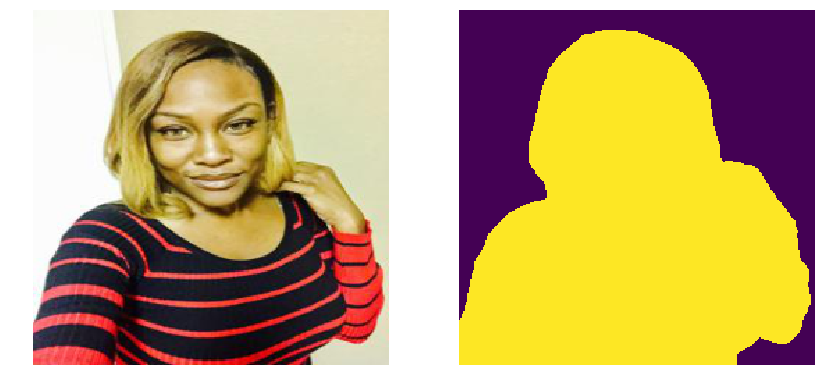

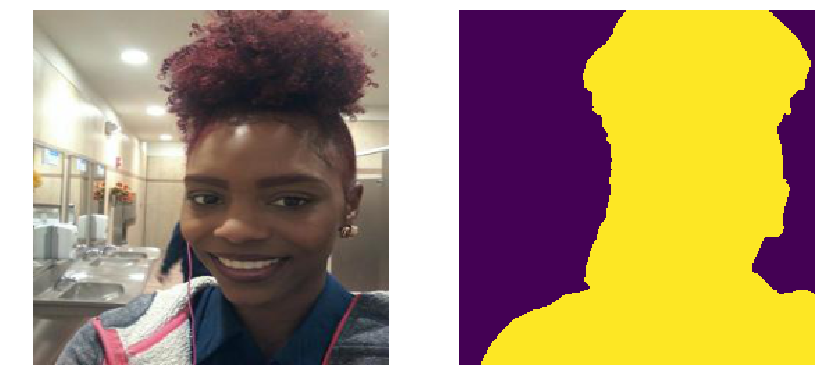

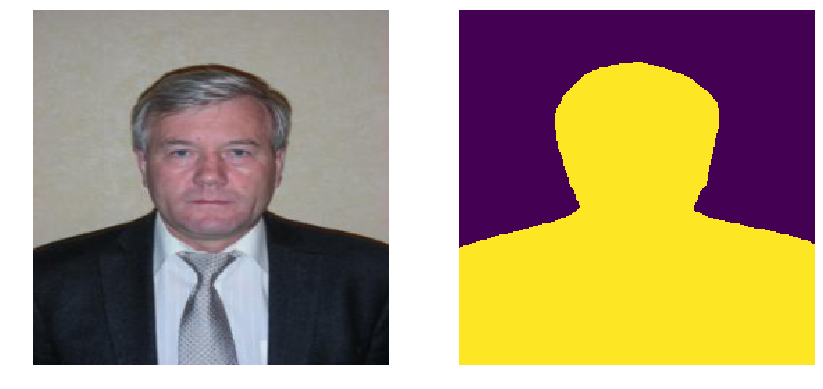

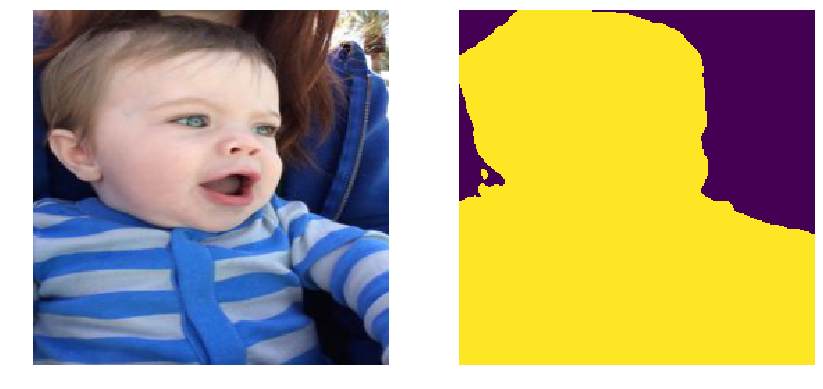

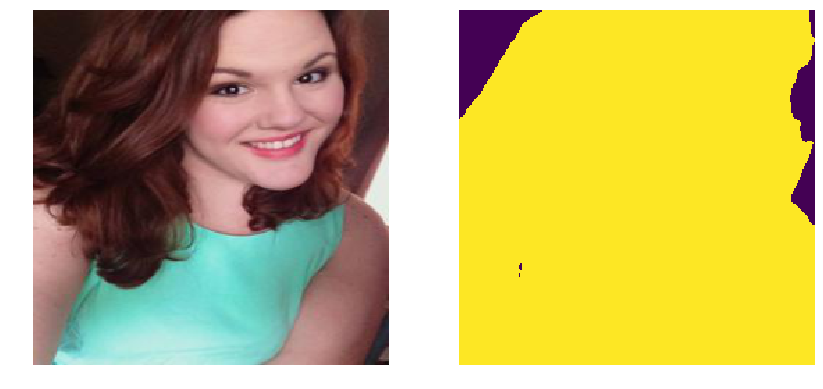

In [134]:
ExamplePred(model_res34,dft)

В целом сеть обучается :)
Достигаемый Dice score = 0,97... Однако, по графикам видно, что обучение результат нестабильно и имеет резкие перепады (например, в конце случилось очень резкое падение). Возможно это связано с тем, что на нетипичных для обученных весов данных градинты проходят вплоть до базовых слоев, где изменяются базовые признаки. Основываясь на этом предположении было решено попробовать заморозить encoder-слои. 

In [0]:
BACKBONE = 'resnet34'
model_res34_freeze = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)

In [0]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best_freeze.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last_freeze.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

In [0]:
epochs=40
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-2/epochs)
model_res34_freeze.compile(
    'Adam',
    loss=sm.losses.jaccard_loss,
    metrics=[sm.metrics.dice_score],
)

In [145]:
batch_size = 16
history2=model_res34_freeze.fit_generator(generate_data(dft, batch_size),
              steps_per_epoch=100,
              epochs=epochs,
              verbose=1,
              callbacks=callbacks,
              validation_data=generate_data(dfv, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=False,
              initial_epoch=0)

Epoch 1/40
100/100 [==============================] - 76s 757ms/step - loss: 0.1837 - score: 0.8894 - val_loss: 0.1000 - val_score: 0.9455
Epoch 2/40
100/100 [==============================] - 61s 612ms/step - loss: 0.0660 - score: 0.9649 - val_loss: 0.0711 - val_score: 0.9613
Epoch 3/40
100/100 [==============================] - 61s 613ms/step - loss: 0.0509 - score: 0.9733 - val_loss: 0.0671 - val_score: 0.9637
Epoch 4/40
100/100 [==============================] - 61s 612ms/step - loss: 0.0455 - score: 0.9762 - val_loss: 0.0697 - val_score: 0.9622
Epoch 5/40
100/100 [==============================] - 61s 611ms/step - loss: 0.0392 - score: 0.9796 - val_loss: 0.0613 - val_score: 0.9666
Epoch 6/40
100/100 [==============================] - 61s 610ms/step - loss: 0.0351 - score: 0.9819 - val_loss: 0.0548 - val_score: 0.9705
Epoch 7/40
100/100 [==============================] - 61s 610ms/step - loss: 0.0326 - score: 0.9831 - val_loss: 0.0563 - val_score: 0.9693
Epoch 8/40
100/100 [=======

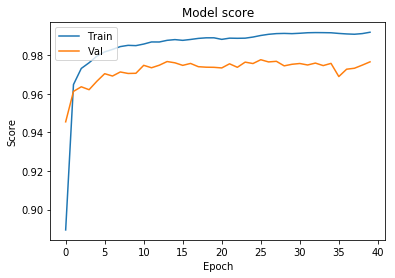

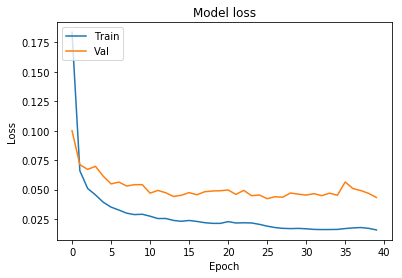

In [146]:
Plot_graph(history2)

(16, 256, 256, 1)


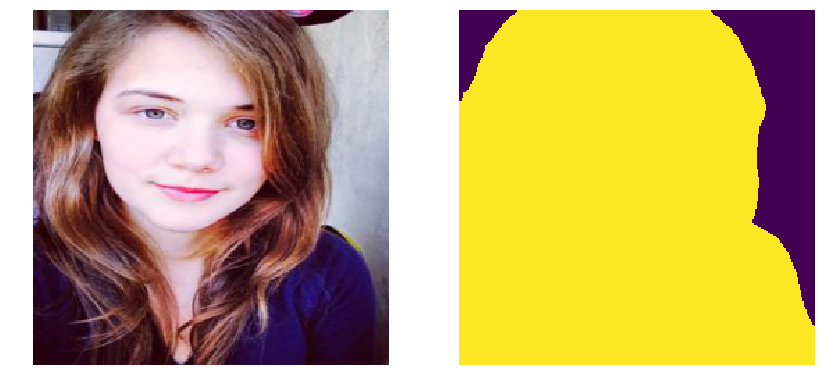

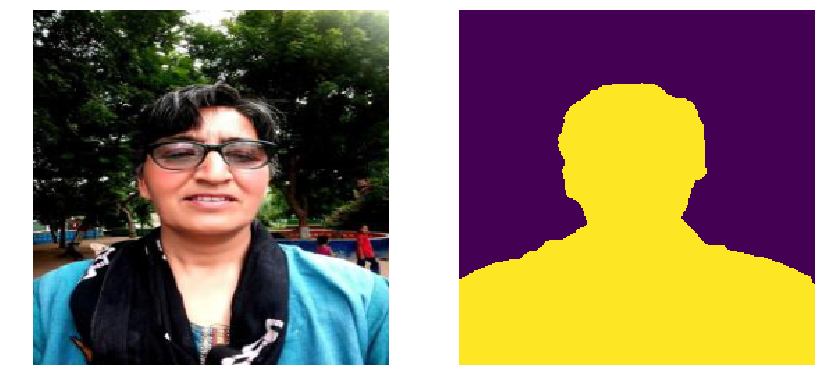

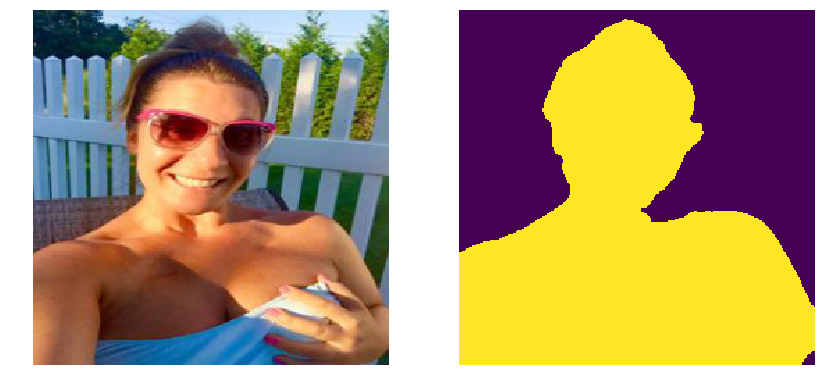

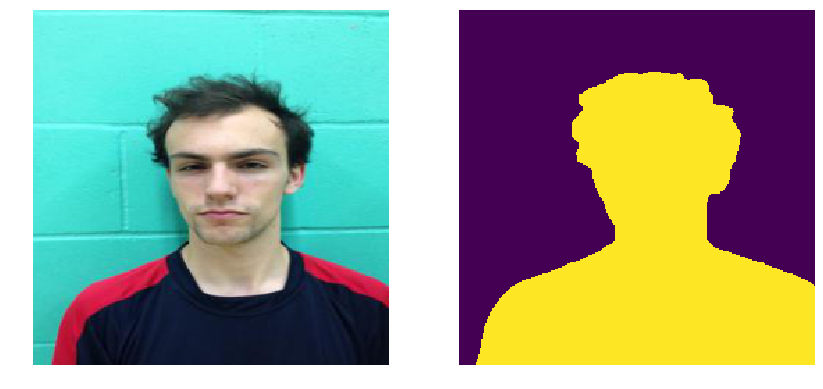

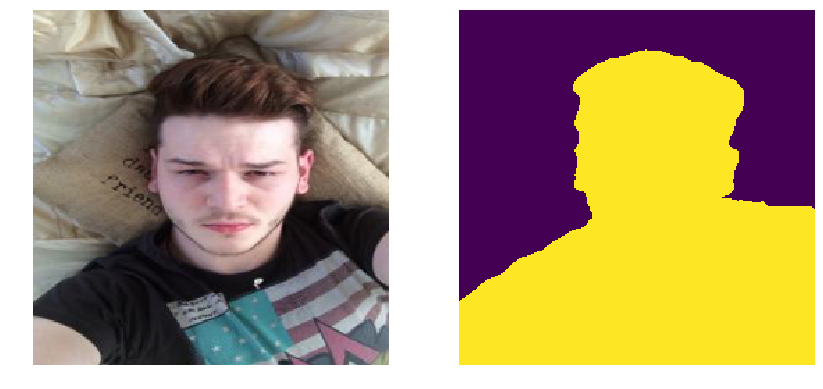

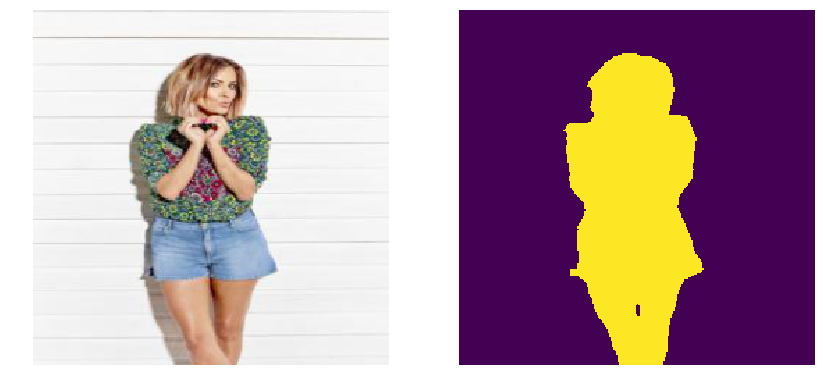

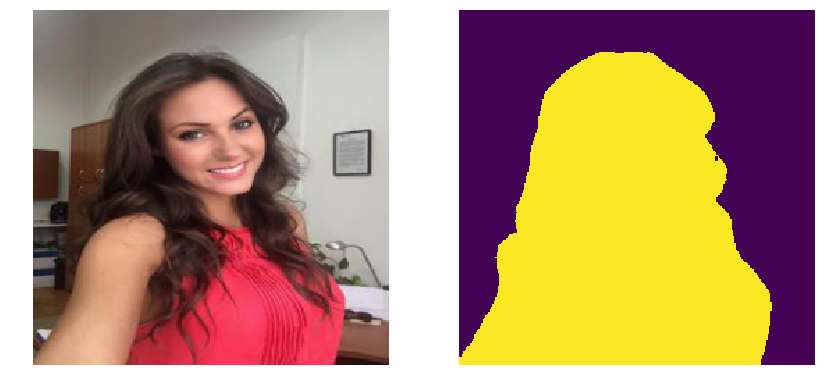

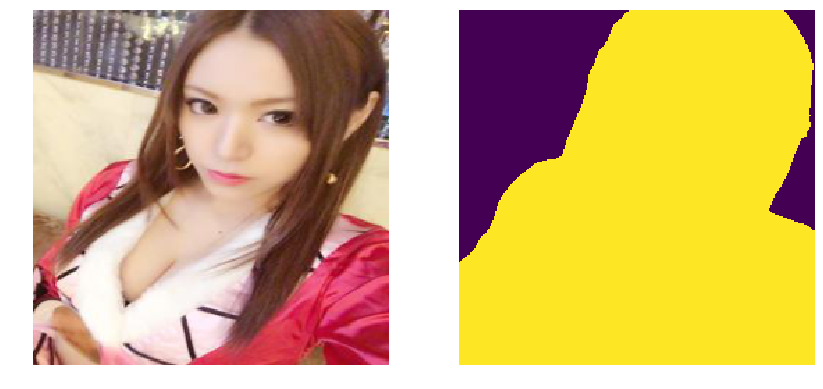

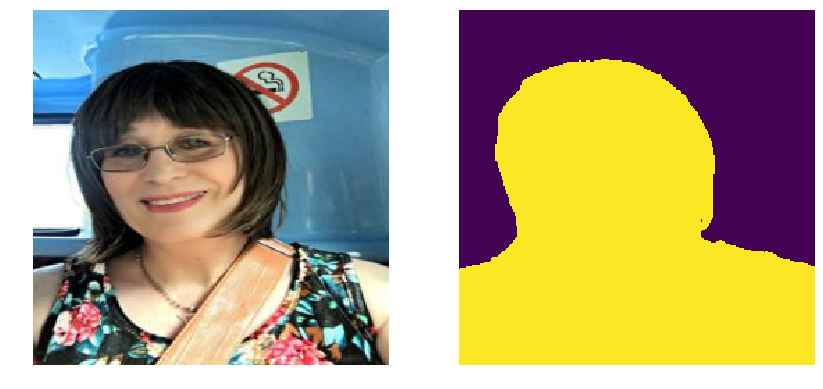

In [147]:
ExamplePred(model_res34_freeze)

Видно, что обучение идет намного стабильнее и сильные перепады отсутствуют. Это позволяет считать, что гипотеза о градиентах верна. Однако виден разрыв между скором на train-e и на валидации. Это говорит о эффекте переобучения (высокий variance). Можно бороться с этим с помощью регуляризации или большего количества данных на обучении, для чего стоит применить аугментацию данных. 

In [0]:
x_tr, y_tr=get_data(dft)

In [0]:
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True)
image_datagen = keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

seed = 1
bs = 16

image_generator = image_datagen.flow(x_tr, seed=seed, batch_size=bs, shuffle=True)
mask_generator = mask_datagen.flow(y_tr, seed=seed, batch_size=bs, shuffle=True)

train_generator = zip(image_generator, mask_generator)

In [0]:
BACKBONE = 'resnet34'
model_res34_freeze_au = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)

In [0]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best_freeze_au.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last_freeze_au.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

In [0]:
epochs=40
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-2/epochs)
model_res34_freeze_au.compile(
    'Adam',
    loss=sm.losses.jaccard_loss,
    metrics=[sm.metrics.dice_score],
)

In [154]:
batch_size = 16
history3=model_res34_freeze_au.fit_generator(train_generator,
              steps_per_epoch=100,
              epochs=epochs,
              verbose=1,
              callbacks=callbacks,
              validation_data=generate_data(dfv, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=False,
              initial_epoch=0)

Epoch 1/40
100/100 [==============================] - 71s 712ms/step - loss: 0.1896 - score: 0.8866 - val_loss: 0.1027 - val_score: 0.9430
Epoch 2/40
100/100 [==============================] - 53s 525ms/step - loss: 0.0917 - score: 0.9499 - val_loss: 0.0781 - val_score: 0.9579
Epoch 3/40
100/100 [==============================] - 52s 524ms/step - loss: 0.0763 - score: 0.9586 - val_loss: 0.0721 - val_score: 0.9608
Epoch 4/40
100/100 [==============================] - 53s 526ms/step - loss: 0.0651 - score: 0.9650 - val_loss: 0.0719 - val_score: 0.9615
Epoch 5/40
100/100 [==============================] - 52s 524ms/step - loss: 0.0637 - score: 0.9659 - val_loss: 0.0626 - val_score: 0.9665
Epoch 6/40
100/100 [==============================] - 53s 528ms/step - loss: 0.0581 - score: 0.9690 - val_loss: 0.0647 - val_score: 0.9656
Epoch 7/40
100/100 [==============================] - 53s 527ms/step - loss: 0.0520 - score: 0.9724 - val_loss: 0.0535 - val_score: 0.9717
Epoch 8/40
100/100 [=======

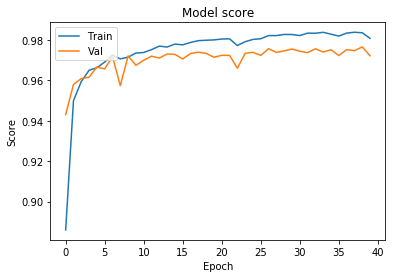

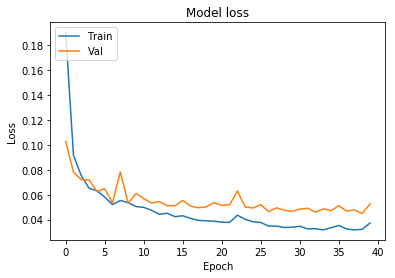

In [155]:
Plot_graph(history3)

Variance уменьшился, однако, похоже, что только лишь из-за уменьшения точности на трейне. Нужно продолжать эксперименты с аугментацией.

---

# Результаты

Создадим датафрейм с предсказаниями на валидации.

In [0]:
df=ResultsValid(model_res34_freeze, dfv)
df.to_csv('/content/results/valid.csv')

Сделаем предсказания на тесте.

In [0]:
pred_masks=np.array(ResultsTest(model_res34_freeze)).astype("uint8")

In [0]:
paths_to_imgs = sorted(glob("data/test/*"))

_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/example2")

In [0]:
!zip -qr /content/resnew.zip /content/results

# Выводы

Изучены основные архитектуры нейросетей и подходы к задаче сегментации.
Инициализированы вспомогательные функции, реализована предобученная модель сегментации U-net с разными параметрами. Проведено сравнение моделей и решена проблема неустойчивости обучения.
Построенные модели дают в среднем 0.973 точности на валидационном датасете. В процессе экспериментов было опробовано много других моделей, но ни одна из них не дала превосходящего результата.
В качестве продолжения работы над данной задачей можно рассматривать:
1. Другие архитектуры сетей для сегментации.
2. Эксперименты с подбором аугментаций.
3. Точечные настройки оптимизатора. Например SGD с точечной настройкой может давать лучшие результаты.
4. Введение регуляризации в слои. Модель с замороженными первыми слоями может давать точность на трейне >0.99. Соответственно, можно пытаться уменьшать variance до достижения этого результата.
5.Большее время обучения моделей.
6. Замораживать слои только на первые несколько эпох с последующей разморозкой.
